# Show that, with a uniform prior, the Bayesian 97.5% credible interval yields a decision threshold approximately equivalent to a Frequentist one-sided p-value of 0.05

In [1]:
import numpy as np
from statsmodels.stats.proportion import proportions_ztest

def frequentist_ab_test(success_a, trials_a, success_b, trials_b):
    """
    Performs a two-proportion z-test for A/B testing.

    Returns:
        p_value: The p-value for the test
        z_stat: The z-statistic (optional for interpretation)
    """
    count = np.array([success_a, success_b])
    nobs = np.array([trials_a, trials_b])
    z_stat, p_value = proportions_ztest(count, nobs)
    return z_stat, p_value


In [10]:
from product_analytics.variant_evaluation import _sample_posterior
import pandas as pd

In [11]:
# Define the function to simulate results over a grid of sample sizes and uplifts
def run_ab_test_grid(sample_sizes, uplifts, baseline_rate=0.04):
    results = []

    for n in sample_sizes:
        for uplift in uplifts:
            # Simulate success counts
            p_a = baseline_rate
            p_b = baseline_rate + uplift
            successes_a = int(p_a * n)
            successes_b = int(p_b * n)

            # Run frequentist test
            z_stat, p_value = frequentist_ab_test(successes_a, n, successes_b, n)

            
            samples_a = _sample_posterior(successes_a, n, 1, 1, sample_size=1_000_000 )
            samples_b = _sample_posterior(successes_b, n, 1, 1, sample_size=1_000_000 )
            
            # Compute Bayesian probability
            prob_b_better = (samples_b > samples_a).mean()

            results.append({
                'Sample Size': n,
                'Uplift (%)': uplift * 100,
                'Conversion B (%)': p_b * 100,
                'Frequentist p-value': round(p_value, 6),
                'Bayesian P(B > A)': round(prob_b_better, 6)
            })

    return pd.DataFrame(results)

# Define input arrays
sample_sizes_test = [100, 500, 1000, 5000, 10000, 50000]
uplifts_test = np.round(np.arange(0.001, 0.031, 0.001), 3)

# Run the grid evaluation
ab_test_results = run_ab_test_grid(sample_sizes_test, uplifts_test)

# Display the result
ab_test_results

,Sample Size,Uplift (%),Conversion B (%),Frequentist p-value,Bayesian P(B > A)
0,100,0.1,4.1,1.0,0.500713
1,100,0.2,4.2,1.0,0.499468
2,100,0.3,4.3,1.0,0.500522
3,100,0.4,4.4,1.0,0.500805
4,100,0.5,4.5,1.0,0.499160
...,...,...,...,...,...
175,50000,2.6,6.6,0.0,1.000000
176,50000,2.7,6.7,0.0,1.000000
177,50000,2.8,6.8,0.0,1.000000
178,50000,2.9,6.9,0.0,1.000000


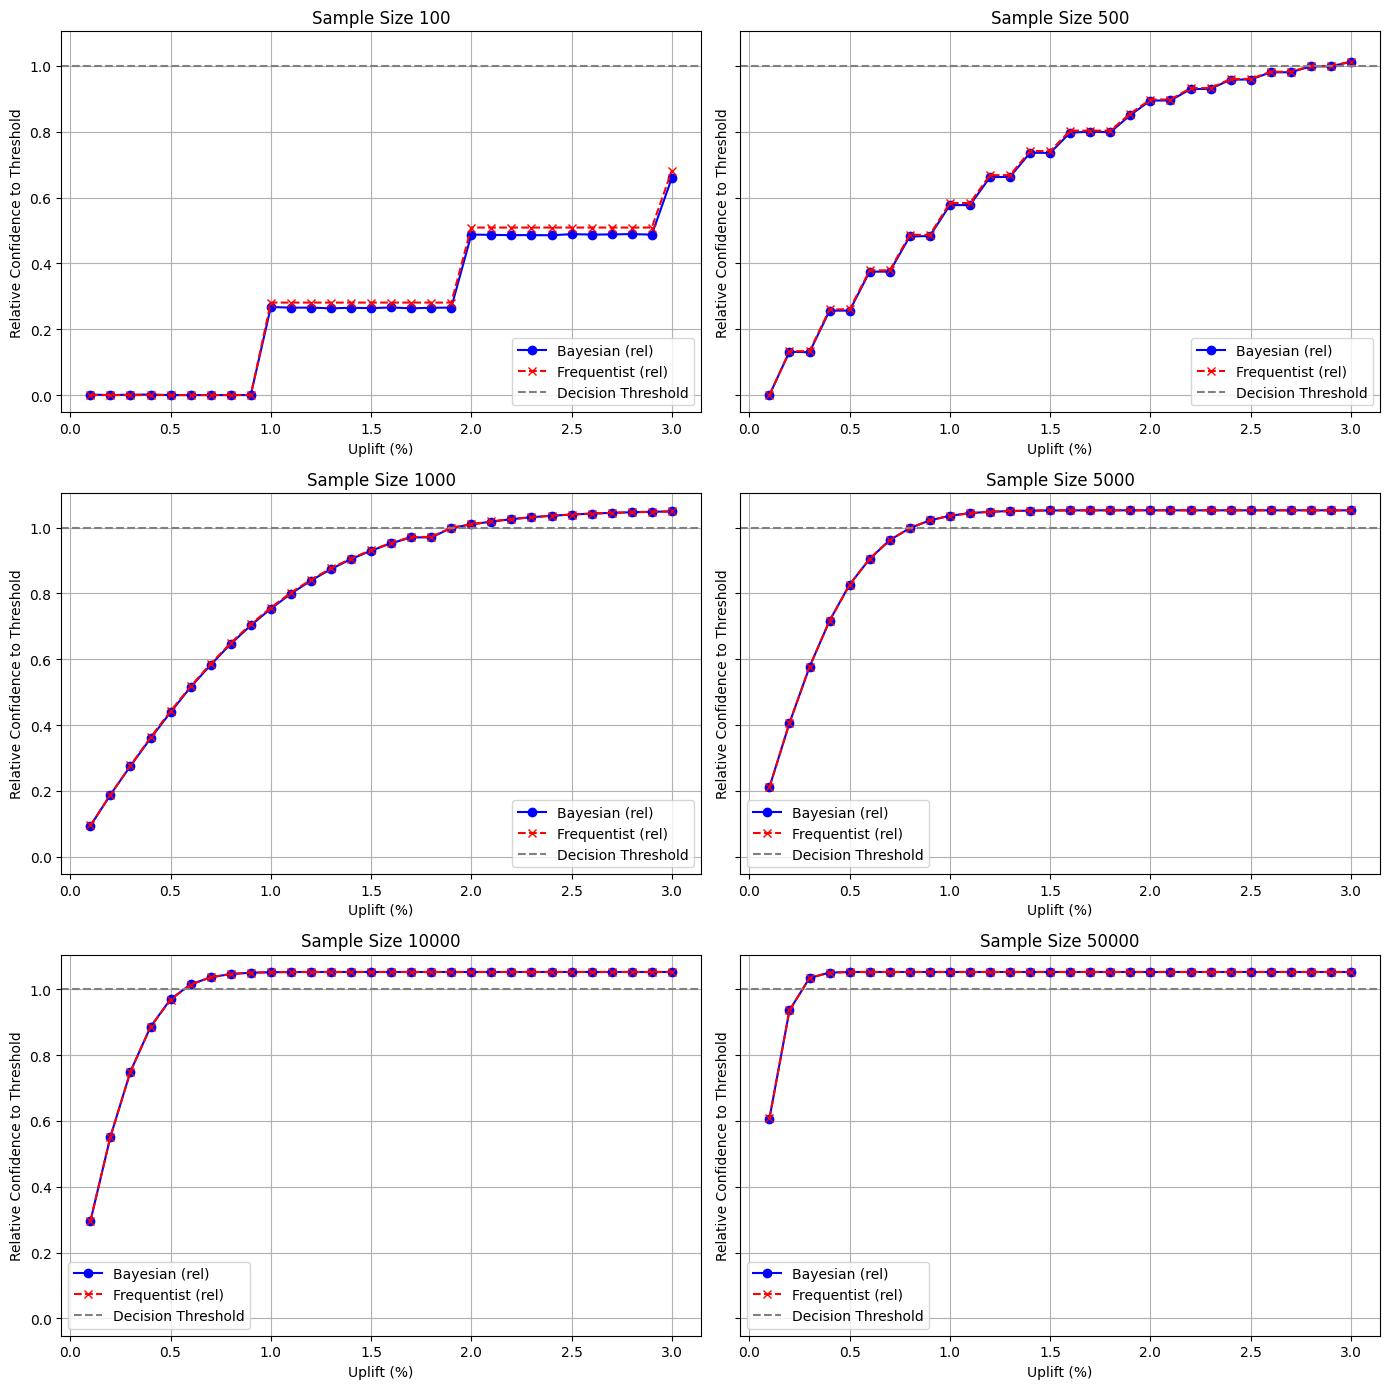

In [12]:
def plot_all_sample_sizes_overlay_relative(df, sample_sizes, target_bayes=0.975):
    """
    Plots Bayesian and frequentist confidence relative to their decision thresholds.
    Values are normalized such that 1.0 means 'crossed decision threshold'.

    Parameters:
    - df: DataFrame with test results
    - sample_sizes: list of sample sizes to plot
    - target_bayes: the Bayesian confidence threshold to treat as 'decision line' (e.g., 0.975 or 0.99)
    """
    import matplotlib.pyplot as plt

    fig, axes = plt.subplots(3, 2, figsize=(14, 14), sharey=True)
    axes = axes.flatten()

    for idx, size in enumerate(sample_sizes):
        subset = df[df['Sample Size'] == size].copy()

        # Normalize both curves so that 1 = decision threshold
        subset['Relative Bayesian'] = (subset['Bayesian P(B > A)'] - 0.5) / (target_bayes - 0.5)
        subset['Relative Bayesian'] = subset['Relative Bayesian'].clip(0, 1.1)

        subset['Relative Frequentist'] = (1 - subset['Frequentist p-value']) / 0.95
        subset['Relative Frequentist'] = subset['Relative Frequentist'].clip(0, 1.1)

        ax = axes[idx]
        ax.plot(subset['Uplift (%)'], subset['Relative Bayesian'], marker='o', label='Bayesian (rel)', color='blue')
        ax.plot(subset['Uplift (%)'], subset['Relative Frequentist'], marker='x', linestyle='--', label='Frequentist (rel)', color='red')
        ax.axhline(1.0, color='gray', linestyle='--', label='Decision Threshold')
        ax.set_title(f"Sample Size {size}")
        ax.set_xlabel("Uplift (%)")
        ax.set_ylabel("Relative Confidence to Threshold")
        ax.grid(True)
        ax.legend()

    plt.tight_layout()
    plt.show()

# Example usage:
plot_all_sample_sizes_overlay_relative(ab_test_results, sample_sizes_test, target_bayes=0.975)